# Importing the libraries

In [1]:
# کتابخانه‌های مورد نیاز
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\mahdis\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Loading, partitionning and normalizing the MNIST dataset

In [2]:
# مرحله ۱و ۲: بارگذاری داده‌ی Fashion-MNIST
# ----------------------------------------------
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.int32)        # تبدیل برچسب‌ها به عدد صحیح
X = X / 255.0                 # نرمال‌سازی مقادیر پیکسل بین 0 تا 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\mahdis\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Visualizing the MNIST dataset

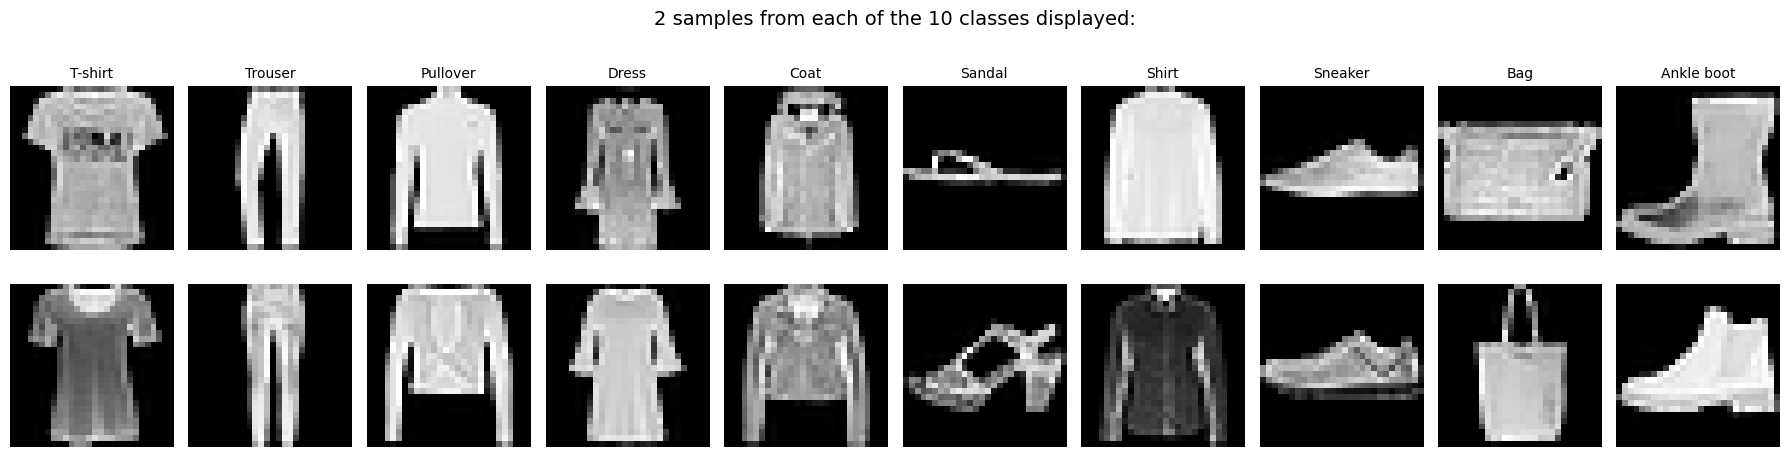

In [5]:
# نمایش ۲ نمونه تصویر از هر یک از ۱۰ کلاس در یک گرید ۲×۱۰
# ----------------------------------------------
import matplotlib.pyplot as plt

# لیست اسامی کلاس‌ها به‌ترتیب برچسب
class_names = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# تعیین اندازه گراف
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 5))

# برای هر کلاس، ۲ تصویر انتخاب و نمایش داده می‌شود
for cls in range(10):
    # پیدا کردن ایندکس‌هایی که به این کلاس تعلق دارند
    idxs = np.where(y_train == cls)[0][:2]
    for i, idx in enumerate(idxs):
        ax = axes[i, cls]
        ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(class_names[cls], fontsize=10)

plt.suptitle("2 samples from each of the 10 classes displayed:", fontsize=14)
plt.tight_layout()
plt.show()


# 3 Training the First Logistic regression with C = 0.001

In [6]:
# مرحله ۳: آموزش اولیه Logistic Regression با پارامترهای خواسته‌شده
# ----------------------------------------------
log_reg = LogisticRegression(
    solver='liblinear',     # حل‌کننده برای داده‌های کوچک یا sparse
    C=0.001,                # قدرت نظم‌دهی (هرچه کمتر، نظم‌دهی بیشتر)
    multi_class='auto',     # انتخاب خودکار بین one-vs-rest و multinomial
    random_state=0,
    penalty='l2',           # جریمه L2
    max_iter=1000
)
log_reg.fit(X_train, y_train)

# پیش‌بینی و محاسبه دقت
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
print("Logistic Regression (C=0.001):")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

Logistic Regression (C=0.001):
Train Accuracy: 0.8119821428571429
Test Accuracy: 0.8065714285714286


# 4 GridSearch with different Cs and 5 folds

In [7]:
# مرحله ۴: تنظیم پارامتر C با GridSearchCV
# ----------------------------------------------
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}
grid_log_reg = LogisticRegression(
    solver='liblinear', multi_class='auto',
    random_state=0, penalty='l2', max_iter=1000
)
grid_search = GridSearchCV(grid_log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best C:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# ارزیابی مدل نهایی با بهترین C روی داده تست
best_model = grid_search.best_estimator_
print("Test Accuracy (Best Model):", best_model.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best C: {'C': 0.3}
Best CV Accuracy: 0.8524642857142857
Test Accuracy (Best Model): 0.8535714285714285


# 5 Confusion Matrix

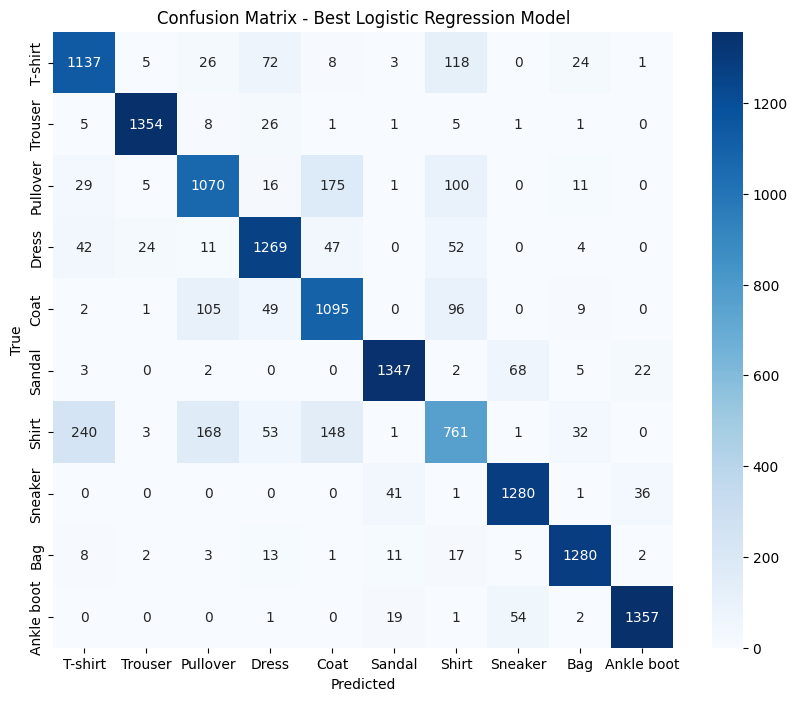

In [8]:
# مرحله ۵: رسم ماتریس درهم‌ریختگی
# ----------------------------------------------
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=[
                "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
            ],
            yticklabels=[
                "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
            ])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Best Logistic Regression Model")
plt.show()

# 6 Training a SGDClassifier

In [9]:
# مرحله 6: آموزش مدل SGDClassifier
# ----------------------------------------------
sgd_clf = SGDClassifier(
    loss='log_loss',        # تابع هزینه معادل logistic regression
    penalty='l2',           # جریمه L2
    random_state=0,         # برای تکرارپذیری
    max_iter=1000, tol=1e-3
)
sgd_clf.fit(X_train, y_train)

# ارزیابی SGD
y_pred_train_sgd = sgd_clf.predict(X_train)
y_pred_test_sgd = sgd_clf.predict(X_test)
print("SGDClassifier:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train_sgd))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_sgd))

SGDClassifier:
Train Accuracy: 0.8486428571428571
Test Accuracy: 0.8369285714285715
